## Import Modules

In [1]:
import src.finbert as fb
import src.ws_yahoo as wsy
import pandas as pd

import os
import glob

In [2]:
# Make folders for article CSVs and sentiment CSVs
# set default path
path = os.getcwd()

try:
    os.chdir(path)
    os.mkdir('./csv/')
    os.mkdir('./sentiment/')
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: './sentiment/'


## Sentiment CSV Creator

In [3]:
# Pulls website articles, puts into Dataframe
# This takes quite a while to run

def main_dataframe_creator(ticker_list, start, end):
    os.chdir(path)   
    
    for item in ticker_list:
        ticker = item
        start = start
        end = end
        df = wsy.dataframe_price_sentiment(ticker, start, end)
        df.to_csv(f'./csv/{item}.csv', index=False)

In [4]:
# Uses article CSVs to create sentiment csvs
# This takes a VERY long time to run

def sentiment_CSV():
    os.chdir(path)
    csv_path = './csv/'
    extension = 'csv'
    os.chdir(csv_path)
    result = glob.glob('*.{}'.format(extension))
    print(result)

    sentiment_path = './sentiment/'
    for item in result:
        # os.chdir(csv_path)
        print(item)
        df_csv = pd.read_csv(item)
        df_sentiment = fb.sentiment_poster(df_csv)
        os.chdir(path)
        os.chdir(sentiment_path)
        df_sentiment.to_csv(f'./{df_sentiment.company[0]}-sentiment.csv')

In [5]:
# Pulls CSVs out from ../sentiment and puts into one single dataframe
# This is the final dataset for feature engineering and the pipeline

def sentiment_dataframe():
    os.chdir(path)
    sentiment_path = './sentiment/'
    extension = 'csv'
    os.chdir(sentiment_path)
    result = glob.glob('*.{}'.format(extension))
    print(result)
    
    df_list = []

    for item in result:
        df = pd.read_csv(item, index_col=0)
        df_list.append(df)

    df_sentiment = pd.concat(df_list, ignore_index=True)
    
    return df_sentiment

## Ticker News Article Scraping

In [ ]:
# ticker_list = ['WPM', 'PAAS', 'HL', 'MAG', 'CDE'] <- example
# currently the ws_yahoo.py only grabs 2 articles, needs to be manually updated in script
ticker_list = ['HBM']
start = '2017-01-01'
end = '2022-11-30'

main_dataframe_creator(ticker_list, start, end)

In [ ]:
# This function generates all the sentiment CSVs from the news articles
# This can take a VERY long time - about 30 seconds per article
# Web scraper generally grabs 80-90 articles per ticker (if no preset limits on)

sentiment_CSV()

In [263]:
# This function compiles all the sentiment csvs into a single dataframe
df = sentiment_dataframe()

['ALB-sentiment.csv', 'BHP-sentiment.csv', 'CDE-sentiment.csv', 'DMLP-sentiment.csv', 'FCX-sentiment.csv', 'HBM-sentiment.csv', 'HL-sentiment.csv', 'LAC-sentiment.csv', 'MAG-sentiment.csv', 'NXE-sentiment.csv', 'PAAS-sentiment.csv', 'RIO-sentiment.csv', 'SBSW-sentiment.csv', 'TMQ-sentiment.csv', 'UEC-sentiment.csv', 'VALE-sentiment.csv', 'WPM-sentiment.csv']


In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,target,company,level_0,...,fb_head_nega,fb_head_neut,fb_body_stmt,fb_head_stmt,b_body_posi,b_body_nega,b_body_stmt,b_head_posi,b_head_nega,b_head_stmt
0,2022-10-25,270.049988,282.209991,268.869995,281.429993,281.429993,1103500,1,ALB,84,...,0.074669,0.183092,2,0,0.322917,0.677083,1.0,0.456038,0.543962,1.0
1,2022-10-25,270.049988,282.209991,268.869995,281.429993,281.429993,1103500,1,ALB,85,...,0.067651,0.781101,2,2,0.613483,0.386517,0.0,0.663944,0.336056,0.0
2,2022-10-25,270.049988,282.209991,268.869995,281.429993,281.429993,1103500,1,ALB,86,...,0.057130,0.748516,2,2,0.634125,0.365875,0.0,0.517696,0.482304,0.0
3,2022-10-25,270.049988,282.209991,268.869995,281.429993,281.429993,1103500,1,ALB,87,...,0.045959,0.400790,2,0,0.445883,0.554117,1.0,0.386318,0.613682,1.0
4,2022-10-25,270.049988,282.209991,268.869995,281.429993,281.429993,1103500,1,ALB,88,...,0.046158,0.778100,2,2,0.517302,0.482698,0.0,0.553063,0.446937,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,2022-11-03,30.910000,31.100000,30.350000,30.670000,30.543993,3512900,0,WPM,6,...,0.047865,0.325755,2,0,0.669675,0.330325,0.0,0.509285,0.490715,0.0
1086,2022-11-03,30.910000,31.100000,30.350000,30.670000,30.543993,3512900,0,WPM,7,...,0.047865,0.325755,2,0,0.506907,0.493093,0.0,0.281582,0.718418,1.0
1087,2022-11-03,30.910000,31.100000,30.350000,30.670000,30.543993,3512900,0,WPM,8,...,0.135735,0.535832,2,2,0.475900,0.524100,1.0,0.495154,0.504846,1.0
1088,2022-11-04,32.270000,34.419998,32.240002,34.299999,34.159077,4257700,1,WPM,4,...,0.458489,0.084172,2,1,0.570510,0.429490,0.0,0.614392,0.385608,0.0


<AxesSubplot: >

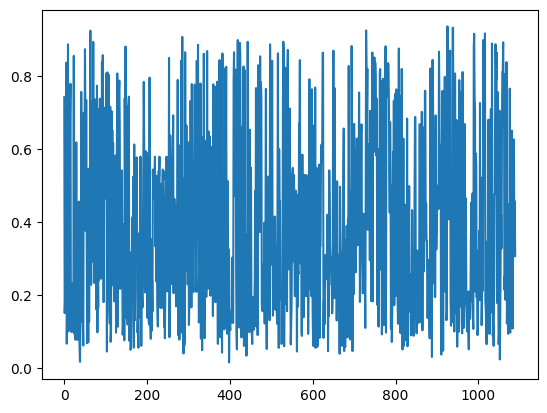

In [11]:
df['fb_head_posi'].plot()

## Feature Engineering

In [12]:
def feature_set1(df):
    # weight of sentiment, depending on which sentiment, the other two weighted against the dominant
    df.loc[df['fb_body_stmt'] == 0, 'fb_body_weight'] = (df['fb_body_posi'] / (df['fb_body_neut'] + df['fb_body_nega']))
    df.loc[df['fb_body_stmt'] == 1, 'fb_body_weight'] = (df['fb_body_nega'] / (df['fb_body_posi'] + df['fb_body_neut']))
    df.loc[df['fb_body_stmt'] == 2, 'fb_body_weight'] = (df['fb_body_neut'] / (df['fb_body_posi'] + df['fb_body_nega']))
    df.loc[df['fb_head_stmt'] == 0, 'fb_head_weight'] = (df['fb_head_posi'] / (df['fb_head_neut'] + df['fb_head_nega']))
    df.loc[df['fb_head_stmt'] == 1, 'fb_head_weight'] = (df['fb_head_nega'] / (df['fb_head_posi'] + df['fb_head_neut']))
    df.loc[df['fb_head_stmt'] == 2, 'fb_head_weight'] = (df['fb_head_neut'] / (df['fb_head_posi'] + df['fb_head_nega']))

    # do the headlines and body sentiments align
    df.loc[df['b_body_stmt'] == df['b_head_stmt'], 'b_alignment'] = 1
    df.loc[df['b_body_stmt'] != df['b_head_stmt'], 'b_alignment'] = 0
    df.loc[df['fb_body_stmt'] == df['fb_head_stmt'], 'fb_alignment'] = 1
    df.loc[df['fb_body_stmt'] != df['fb_head_stmt'], 'fb_alignment'] = 0
    df.loc[df['b_alignment'] == df['fb_alignment'], 'all_alignment'] = 1
    df.loc[df['b_alignment'] != df['fb_alignment'], 'all_alignment'] = 0

    # get dummies
    df = pd.concat([df, pd.get_dummies(df['b_body_stmt'], prefix='b_body_stmt')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['b_head_stmt'], prefix='b_head_stmt')], axis=1)

    df = pd.concat([df, pd.get_dummies(df['fb_body_stmt'], prefix='fb_body_stmt')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['fb_head_stmt'], prefix='fb_head_stmt')], axis=1)

    columns_to_drop = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',  # Financial columns
    'company', 'level_0', 'index', 'url', 'headline' , 'source', 'body', 'date' # Categorical columns
    ]

    df_final = df.drop(columns=columns_to_drop).reset_index(drop=True)

    return df_final

In [13]:
df_final = feature_set1(df)

## ML Pipeline

#### Modules

In [14]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb


## WARNINGS ARE TURNED OFF ##

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()  
xboost = xgb.XGBClassifier()

#### Datamodel Functions

In [15]:
def datamodel_creation(df):
    # Identify numeric and categorical features, columns to keep and drop
    drop_feats = ['b_body_stmt', 'b_head_stmt', 'fb_body_stmt', 'fb_head_stmt']
    target_feat = ['target']

    df_target = df[target_feat]
    df_pipeline = df.drop(columns=target_feat)
    model_feats = df_pipeline.columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(df_pipeline, df_target, test_size=0.20, random_state=42)

    datamodel = [X_train, y_train, X_test, y_test]

    return datamodel, model_feats

#### Metrics and Pipeline

In [16]:
def metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    metrics_list = [recall, precision, accuracy, f1, roc_auc]
    metrics_tag = ['recall', 'precision', 'accuracy', 'f1 score', 'roc auc score']
    metrics_def = [
        '--> Recall is the fraction correctly identified as positive out of all predicted positives',
        '--> Precision is the fraction correctly identified as positive out of all positives',
        '--> Accuracy is the fraction of predictions our model got correct',
        '--> F1 Score is the harmonic mean of models precision and recall',
        '--> ROC-AUC Score shows the performance of the model at all classification levels']

    for i in range(len(metrics_list)):
        print(f'the {metrics_tag[i]} is: {metrics_list[i]} {metrics_def[i]}')

    print(f'the confusion matrix is:\n{cm}')

    return metrics_list

In [17]:
def pipeline(model, datamodel):

    numeric_transform = Pipeline([
        ('scaling', StandardScaler()),
        ('select_k_best', SelectKBest(k=3))
    ])

    preprocessing = ColumnTransformer([
        ('numeric', numeric_transform, model_feats),
    ])

    union = FeatureUnion([
        ('pca', PCA(n_components=3)),
        ('select_k_best', SelectKBest(k=3))
    ])

    pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('features', union),
        ('model', model)
    ])

    if model == lr:
        params = {
            'features__pca__n_components': [1, 2, 3, 4, 5],
            'features__select_k_best__k': [1, 2, 3, 4, 5],
            'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'model__penalty': ['1l', 'l2', 'elasticnet', 'none']
        }
    elif model == rfc:
        params = {
            'features__pca__n_components': [1, 2, 3, 4, 5],
            'features__select_k_best__k': [1, 2, 3, 4, 5],
            # 'model__criterion' : ["gini", "entropy", "log_loss"],
            'model__max_depth': [10, 25, 50, 100],
            'model__n_jobs' : [-1],
            # 'model__max_features': ["sqrt", "log2", None],
            'model__n_estimators': [10, 50, 75, 100, 250]
        }
    elif model == gbc:
        params = {
            'features__pca__n_components': [1, 2, 3, 4, 5],
            'features__select_k_best__k': [1, 2, 3, 4, 5],
            'model__n_estimators': [50, 75, 100, 250, 500]
        }
    elif model == xboost:
        params = {
        'model__max_depth': [2, 3, 4, 5, 6],
        'model__eta': [1, 2, 3], 
        'model__nthread': [-1],
        'model__objective': ['binary:logistic']
        }

    # model = pipeline.fit(datamodel[0], datamodel[1])

    grid_search = GridSearchCV(pipeline, params, verbose=0)
    model = grid_search.fit(datamodel[0], datamodel[1])
    print(f'The parameters were:\n{grid_search.best_params_}') 
    print(f'The best score was: {grid_search.best_score_}')

    y_pred = model.predict(datamodel[2])
    y_prob = model.predict_proba(datamodel[2])
    y_best = model.best_score_
    # y_feats = grid_search.feature_importances_

    metrics_list = metrics(datamodel[3], y_pred)
    
    return model, metrics_list, y_prob, y_pred, y_best

#### Function Runs

In [18]:
datamodel, model_feats = datamodel_creation(df_final)

In [19]:
# 16.8s
model_lr, metrics_lr, prob_lr, pred_lr, best_lr = pipeline(lr, datamodel)

The parameters were:
{'features__pca__n_components': 1, 'features__select_k_best__k': 2, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
The best score was: 0.520656814449918
the recall is: 0.3177570093457944 --> Recall is the fraction correctly identified as positive out of all predicted positives
the precision is: 0.4927536231884058 --> Precision is the fraction correctly identified as positive out of all positives
the accuracy is: 0.5045871559633027 --> Accuracy is the fraction of predictions our model got correct
the f1 score is: 0.38636363636363635 --> F1 Score is the harmonic mean of models precision and recall
the roc auc score is: 0.5012208470152396 --> ROC-AUC Score shows the performance of the model at all classification levels
the confusion matrix is:
[[76 35]
 [73 34]]


In [20]:
# 1m 25.6s
model_rfc, metrics_rfc, prob_rfc, pred_rfc, best_rfc = pipeline(rfc, datamodel)

The parameters were:
{'features__pca__n_components': 3, 'features__select_k_best__k': 3, 'model__max_depth': 25, 'model__n_estimators': 10, 'model__n_jobs': -1}
The best score was: 0.5595862068965518
the recall is: 0.3644859813084112 --> Recall is the fraction correctly identified as positive out of all predicted positives
the precision is: 0.4588235294117647 --> Precision is the fraction correctly identified as positive out of all positives
the accuracy is: 0.47706422018348627 --> Accuracy is the fraction of predictions our model got correct
the f1 score is: 0.40624999999999994 --> F1 Score is the harmonic mean of models precision and recall
the roc auc score is: 0.47503578344699837 --> ROC-AUC Score shows the performance of the model at all classification levels
the confusion matrix is:
[[65 46]
 [68 39]]


In [21]:
# 21.7s
model_gbc, metrics_gbc, prob_gbc, pred_gbc, best_gbc = pipeline(gbc, datamodel)

The parameters were:
{'features__pca__n_components': 3, 'features__select_k_best__k': 3, 'model__n_estimators': 50}
The best score was: 0.5515796387520525
the recall is: 0.32710280373831774 --> Recall is the fraction correctly identified as positive out of all predicted positives
the precision is: 0.5303030303030303 --> Precision is the fraction correctly identified as positive out of all positives
the accuracy is: 0.5275229357798165 --> Accuracy is the fraction of predictions our model got correct
the f1 score is: 0.4046242774566474 --> F1 Score is the harmonic mean of models precision and recall
the roc auc score is: 0.5239117622295192 --> ROC-AUC Score shows the performance of the model at all classification levels
the confusion matrix is:
[[80 31]
 [72 35]]


In [22]:
# 2.8s
model_xgb, metrics_xgb, prob_xgb, pred_xgb, best_xgb = pipeline(xboost, datamodel)

The parameters were:
{'model__eta': 2, 'model__max_depth': 5, 'model__nthread': -1, 'model__objective': 'binary:logistic'}
The best score was: 0.5481970443349754
the recall is: 0.616822429906542 --> Recall is the fraction correctly identified as positive out of all predicted positives
the precision is: 0.528 --> Precision is the fraction correctly identified as positive out of all positives
the accuracy is: 0.5412844036697247 --> Accuracy is the fraction of predictions our model got correct
the f1 score is: 0.5689655172413793 --> F1 Score is the harmonic mean of models precision and recall
the roc auc score is: 0.5426454491875052 --> ROC-AUC Score shows the performance of the model at all classification levels
the confusion matrix is:
[[52 59]
 [41 66]]


#### Model Metrics and Graphics

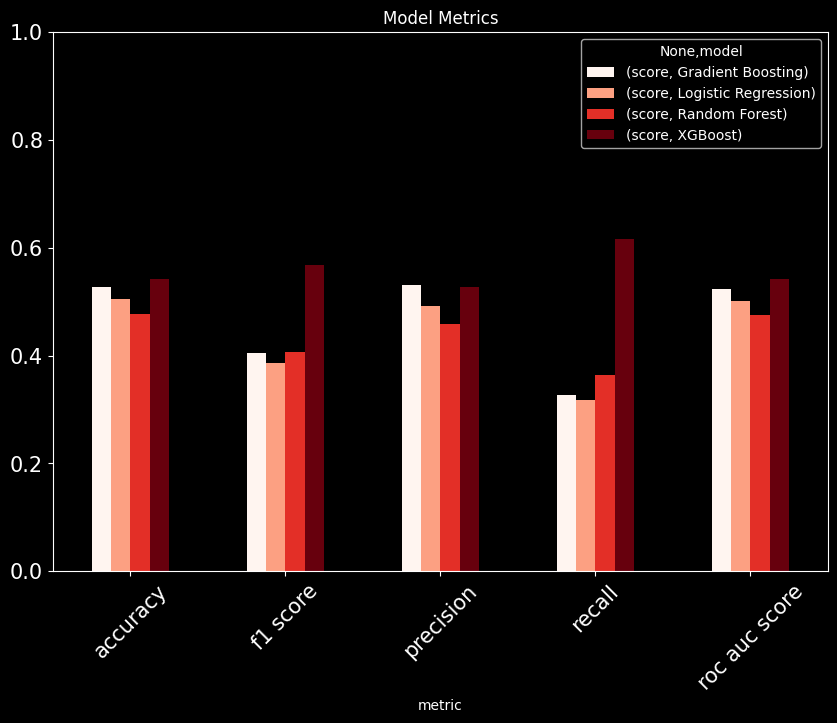

In [45]:
import numpy as np
import matplotlib.pyplot as plt
metrics_tag = ['recall', 'precision', 'accuracy', 'f1 score', 'roc auc score']
model_bests = [best_lr, best_rfc, best_gbc, best_xgb]

plt.style.use('dark_background')

df_met_lr = pd.DataFrame(np.array(metrics_lr).reshape(1,-1), columns=metrics_tag).T
df_met_lr['model'] = 'Logistic Regression'
df_met_rfc = pd.DataFrame(np.array(metrics_rfc).reshape(1,-1), columns=metrics_tag).T
df_met_rfc['model'] = 'Random Forest'
df_met_gbc = pd.DataFrame(np.array(metrics_gbc).reshape(1,-1), columns=metrics_tag).T
df_met_gbc['model'] = 'Gradient Boosting'
df_met_xgb = pd.DataFrame(np.array(metrics_xgb).reshape(1,-1), columns=metrics_tag).T
df_met_xgb['model'] = 'XGBoost'


df_met = pd.concat([df_met_lr, df_met_rfc, df_met_gbc, df_met_xgb])
df_met = df_met.reset_index()
df_met = df_met.rename(columns={'index':'metric', 0:'score'})
df_met

graph = pd.pivot_table(
    df_met,
    values=['score'],
    index=['metric'],
    columns=['model'],
    aggfunc=np.sum,
)

p = graph.plot(
    kind='bar', 
    ylim=(0,1),
    title='Model Metrics',
    figsize=(10,7),
    fontsize=15,
    rot=45,
    colormap='Reds'
)

In [50]:
model_xgb, metrics_xgb, prob_xgb, pred_xgb, 
best_xgb

0.5481970443349754

#### New Graphs

In [333]:
df1 = datamodel[3]
# df1['xgb_pred'] = pred_xgb
# df.drop(columns='target', inplace=True)
x = df1.join(df)
x.loc[x['results'] == x['target'], 'correct'] = 1
x.loc[x['results'] != x['target'], 'correct'] = 0

In [350]:
y = pd.pivot_table(
    x,
    values=['correct'],
    index=['source'],
    # margins_name='Publisher',
    aggfunc='sum'
)
x1 = y.join(x.source.value_counts())
# x1.reset_index(names='Publisher', inplace=True)
x1['Publisher Accuracy'] = np.round((x1.correct / x1.source),4)*100
x2 = x1[(x1['Publisher Accuracy'] > 50) & (x1['Publisher Accuracy'] < 100)].sort_values('Publisher Accuracy', ascending=False)
x2.rename(columns={
    'correct':'Correct Model Predictions',
     'source':'# of Publisher Predictions'
    }, inplace=True
    )

In [351]:
x2

,Correct Model Predictions,# of Publisher Predictions,Publisher Accuracy
source,,,
CNW Group,11.0,13,84.62
PR Newswire,11.0,15,73.33
GlobeNewswire,14.0,21,66.67
Reuters,6.0,9,66.67
TipRanks,2.0,3,66.67
InvestorPlace,8.0,13,61.54
Simply Wall St.,8.0,14,57.14
Zacks,33.0,61,54.10


<AxesSubplot: title={'center': 'News Source'}, xlabel='source'>

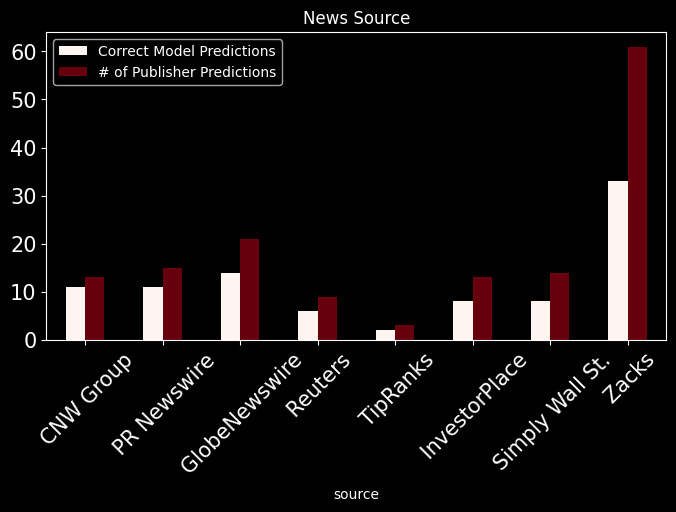

In [353]:
x2[['Correct Model Predictions', '# of Publisher Predictions']].plot.bar(
    title='News Source',
    figsize=(8,4),
    fontsize=15,
    rot=45,
    colormap='Reds'
)

In [425]:
df_test_pub_frequency = pd.pivot_table(
    x,
    values=['url'],
    index=['source'],
    aggfunc='count'
)

len_pub = int(df_test_pub_frequency.sum().values)
len_pub

df_test_pub_frequency.reset_index(names='Publisher', inplace=True)
df_test_pub_frequency['Testset Frequency'] = np.round((df_test_pub_frequency.url / len_pub),4)*100

# df_test_pub_frequency[['Publisher', 'Dataset Frequency']].sort_values('Dataset Frequency', ascending=False)
df_y = df_test_pub_frequency[['Publisher', 'Testset Frequency']].sort_values(by='Publisher')

In [426]:
df_pub_frequency = pd.pivot_table(
    df,
    values=['url'],
    index=['source'],
    aggfunc='count'
)

len_pub_df = int(df_pub_frequency.sum().values)
len_pub_df

df_pub_frequency.reset_index(names='Publisher', inplace=True)
df_pub_frequency['Dataset Frequency'] = np.round((df_pub_frequency.url / len_pub_df),4)*100

# df_pub_frequency[['Publisher', 'Testset Frequency']].sort_values('Testset Frequency', ascending=False)
df_x = df_pub_frequency[['Publisher', 'Dataset Frequency']].sort_values(by='Publisher')

In [430]:
df_frequencies = pd.merge(df_x,df_y, on='Publisher')
df_frequencies.sort_values(by='Dataset Frequency', ascending=False).head()

,Publisher,Dataset Frequency,Testset Frequency
21,Zacks,21.65,27.98
6,GlobeNewswire,11.28,9.63
8,Insider Monkey,8.99,10.09
14,PR Newswire,7.61,6.88
4,CNW Group,7.16,5.96


In [428]:
x2

,Correct Model Predictions,# of Publisher Predictions,Publisher Accuracy
source,,,
CNW Group,11.0,13,84.62
PR Newswire,11.0,15,73.33
GlobeNewswire,14.0,21,66.67
Reuters,6.0,9,66.67
TipRanks,2.0,3,66.67
InvestorPlace,8.0,13,61.54
Simply Wall St.,8.0,14,57.14
Zacks,33.0,61,54.10
